In [1]:
import os
import argparse
import glob
import sys 
import yaml 
import glob

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.backends.backend_pdf import PdfPages

from scipy import interpolate 
from scipy import signal

from pathlib import Path
sys.path.append(str(Path('.').absolute().parent.parent))
from util.paths import find, list_subdirs

import matplotlib as mpl
mpl.rcParams.update({'font.size':         24,
                     'axes.linewidth':    3,
                     'xtick.major.size':  5,
                     'xtick.major.width': 2,
                     'ytick.major.size':  5,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':  "Arial",
                     'font.family':      "sans-serif",
                    })
pd.set_option('display.max_rows', None)


In [2]:
trial=1
# base_path = Path('~/NewMonster/T/OptoPreyCapture').expanduser()
base_path = Path('T:/BinocOptoPreyCapture').expanduser()
fpath = str(list((base_path / '081621/PVCha2black/{:d}/'.format(trial)).glob('*_BasicParams.h5'))[0])


In [3]:
with pd.HDFStore(fpath) as store:
    data = store['df']
    metadata = store.get_storer('df').attrs.metadata

In [4]:
metadata

{'MovieT': 24.833333333333332,
 'CaptureT': 19.316666666666666,
 'TimeToApproach': 4.519014999998035,
 'FreqApproach': 0.24161073825503357,
 'ProbInter': 0.3333333333333333,
 'ProbCapture': 0.5}

In [86]:
with PdfPages(fpath[:-3] + '_Plots.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(data['t'],data['Angle'], c='b')
    ax.plot(data['t'],data['Speed'], c='k')
    ax.plot(data['t'],data['Dist'], c='m')
    ax.axvline(x=metadata['TimeToApproach'], c='g')
    ax.axvline(x=metadata['CaptureT'], c='r')
    ax.set_title('Basic Params')
    ax.legend(['Angle', 'Speed', 'Dist. to Cricket', 'TimeToApproach', 'CaptureT'], bbox_to_anchor=(1.01, 1), fontsize=10)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

    fig, ax = plt.subplots(figsize=(10,8))
    plot_min, plot_max = np.nanmin(data[['Mouse_x','Mouse_y','Cricket_x','Cricket_y']].to_numpy()), np.nanmax(data[['Mouse_x','Mouse_y','Cricket_x','Cricket_y']].to_numpy())
    ax.plot(data['Mouse_y'], data['Mouse_x'],c='k')
    ax.plot(data['Cricket_y'], data['Cricket_x'],c='r')
    ax.set_xlim([plot_min-1,plot_max+1])
    ax.set_ylim([plot_min-1,plot_max+1])
    ax.set_title('DLC Tracking')
    ax.legend(['Mouse', 'Cricket'],bbox_to_anchor=(1.01, 1), fontsize=10)
    ax.set_aspect('equal', 'box')
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

In [22]:
# csv_filepath = os.path.normpath('T:/OptoPreyCapture/csv_today.csv')
csv_filepath = base_path / 'csv_today.csv'
csv = pd.read_csv(csv_filepath)
csv['experiment_date'] = pd.to_datetime(csv['experiment_date'],infer_datetime_format=True,format='%m%d%Y').dt.strftime('%m%d%y')
csv = csv.loc[(csv['run_preprocessing'] == True)|(csv['run_ephys_analysis'] == True)]
csv = csv[csv['experiment_outcome']=='good'].reset_index(drop=True)
# Format Pandas Dataframe to have Trial number and Stimulus condition

cols = list(csv.keys()[:-4])
cols.append('Trial')
cols.append('LaserOn')
csv2 = pd.DataFrame(columns=cols)
for ind,row in csv.iterrows():
    for n in range(1,5):
        if '*' in row['{:d}'.format(n)]:
            csv2 = csv2.append(row[:-4].append(pd.Series([n,True],index=['Trial','LaserOn'])),ignore_index=True)
        else:
            csv2 = csv2.append(row[:-4].append(pd.Series([n,False],index=['Trial','LaserOn'])),ignore_index=True)
inds, labels = csv2['Environment'].factorize()

In [9]:
cs2 = csv2[csv2['animal_name']!='PVCH13p3RT']

In [23]:
df_meta = pd.DataFrame(columns=list(metadata.keys()))
for ind, row in csv2.iterrows():
    if list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5')) != []:
        fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5'))[0])
        with pd.HDFStore(fname) as store:
            data = store['df']
            metadata = store.get_storer('df').attrs.metadata
            metadata.update(csv2[['animal_name','experiment_date','Trial','LaserOn','Environment']].iloc[ind])
            df_meta = df_meta.append(metadata, ignore_index=True)

In [24]:
df_meta.groupby(['LaserOn','Environment']).mean()

,,MovieT,CaptureT,TimeToApproach,FreqApproach,ProbInter,ProbCapture
LaserOn,Environment,,,,,,
False,Lno,43.870588,41.520588,9.505834,0.212045,0.644102,0.386230
True,Lno,45.915079,43.446032,9.535779,0.170785,0.477201,0.467914


In [15]:
import seaborn as sns


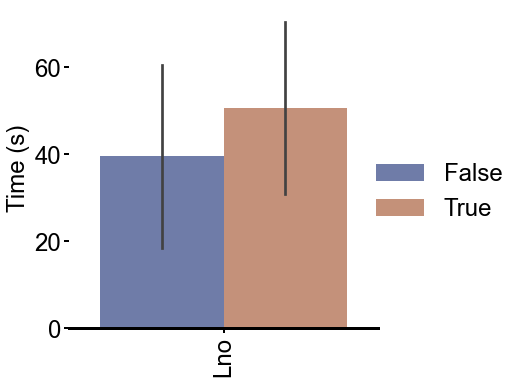

In [17]:
# plt.figure(figsize=(20,20))
g = sns.catplot(
    data=df_meta, kind="bar",
    x="Environment", y="CaptureT", hue="LaserOn",
    ci='sd', palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Time (s)")
g.legend.set_title("")
g.set_xticklabels(rotation=90)
plt.show()

In [18]:
metadata.keys()

dict_keys(['MovieT', 'CaptureT', 'TimeToApproach', 'FreqApproach', 'ProbInter', 'ProbCapture', 'animal_name', 'experiment_date', 'Trial', 'LaserOn', 'Environment'])